In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.4 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForTokenClassification
from transformers import pipeline
import pandas as pd
import string
from collections import Counter
import json
from google.colab import drive
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

##Choose correct directory!

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/'Colab Notebooks'/'DigiHum projekt'/'andmed'

/content/drive/MyDrive/Colab Notebooks/DigiHum projekt


In [ ]:


class ClickBateDataPipeline():

  def __init__(self):
    self.POS_MODEL = 'tartuNLP/EstBERT_UPOS_128'
    self.NER_MODEL = 'tartuNLP/EstBERT_NER'

    self.pos = self.initializePosAnalyses()
    self.ner = self.initializeNerAnalyses()

    self.df = pd.DataFrame(columns=[
      'sentence',
      'article_url',
      'has_adjective',
      'no_adjectives', # no – "number of"
      'has_verb',
      'no_verbs',
      'has_name',
      'no_names',
      'no_words_starting_with_capslock',
      'no_words_with_only_capslock',
      'has_exclamation_mark',
      'has_question_mark',
      'has_numbers',
      'starts_with_number',
      'no_words',
      'no_characters',
      'contains_gtp_reccomended_word',
      'label',
      ])


  def initializePosAnalyses(self): #Part-of-speech
    model = self.POS_MODEL
    tokenizer = self.POS_MODEL
    return pipeline('ner', model=model, tokenizer=tokenizer)


  def initializeNerAnalyses(self):
    model = BertForTokenClassification.from_pretrained(self.NER_MODEL)
    tokenizer = BertTokenizer.from_pretrained(self.NER_MODEL, model_max_length=512)

    return pipeline("ner", model=model, tokenizer=tokenizer)


  def getContainsGtpReccomendedWord(self, tokens):
    gtpWords = ['imelik','uskumatu','šokeeriv','ebatavaline','mõtlemapanev','hämmastav', 'mõistatamatu', 'šokeeriv','mõtlemapanev','uskumatu','imelik', 'hea', 'halb',]

    return 1 if any(word in gtpWords for word in tokens) else 0

  def addSentence(self, sentence, article_url='', label=1):
    tokens = sentence.translate(str.maketrans('', '', string.punctuation)).lower().split(' ')

    names = self.ner(sentence)
    pos = Counter(map(lambda label: label['entity'], self.pos(sentence)))

    self.df.loc[len(self.df.index)] = [
      sentence, #sentence
      article_url, #article_url
      1 if (pos['ADJ'] > 0) else 0, #has_adjective
      pos['ADJ'], #no_adjectives
      1 if (pos['VERB'] > 0) else 0, #has_verb
      pos['VERB'], #no_verbs
      1 if (len(names) > 0) else 0, #has_name
      len(names), #no_names
      len([word for word in sentence.split() if word[0].isupper()]), #no_words_starting_with_capslock
      1 if (len([word for word in sentence.split() if word.isupper()]) > 0) else 0, #no_words_with_only_capslock
      1 if (len([letter for letter in sentence if letter == '!']) > 0) else 0, #has_exclamation_mark
      1 if (len([letter for letter in sentence if letter == '?']) > 0) else 0, #has_question_mark
      1 if (len([letter for letter in sentence if letter.isdigit()]) > 0) else 0, #has_numbers
      1 if type(sentence[0]) == int else 0, #starts_with_number
      len(tokens), #no_words
      len(''.join(tokens)), #no_characters
      self.getContainsGtpReccomendedWord(tokens), #contains_gtp_reccomended_word
      label, #label
    ]


  def getDf(self):
    return self.df


In [ ]:
with open('clickbait-data.json') as json_file:
    clickbait = json.load(json_file)

with open('not-clickbait-data.json') as json_file:
    unbait = json.load(json_file)

In [ ]:
# Initialize pipeline (also resets data)
clickBateDataPipeline = ClickBateDataPipeline()

for article in tqdm(clickbait):
  clickBateDataPipeline.addSentence(article['articleTitle'], article['articleUrl'], 1)

for article in tqdm(unbait):
  clickBateDataPipeline.addSentence(article['articleTitle'], article['articleUrl'], 0)

Downloading:   0%|          | 0.00/996 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/410k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/814 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/410k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


In [ ]:
df = clickBateDataPipeline.getDf()
df.to_csv('data.csv', index=False)

In [ ]:
clickbaitText = ' '.join([article['articleTitle'] for article in clickbait])
unbaitText = ' '.join([article['articleTitle'] for article in unbait])

In [ ]:
stopWords = []
with open('estonian-stopwords.txt') as file:
  stopWords = list(map(lambda f: f.split('\n')[0], list(file)))

stopWords = list(map(lambda word: word.lower(), stopWords))
stopWords.append('|')

In [ ]:
a = [1,2,3,4]

2 in a

True

In [ ]:
# Removing stopwords
clickbaitText = ' '.join(list(filter(lambda word: word not in stopWords, clickbaitText.split(' '))))
unbaitText = ' '.join(list(filter(lambda word: word not in stopWords, unbaitText.split(' '))))

In [ ]:
# Params taken from https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214
def getWordCloud(text):
  wordcloud = WordCloud(
      colormap='RdYlGn',
      background_color='white',
      contour_color='#5d0f24',
      contour_width=3
  ).generate(text)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

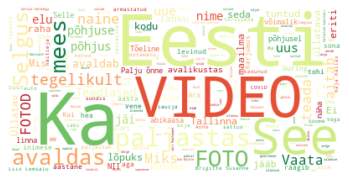

In [ ]:
getWordCloud(clickbaitText)

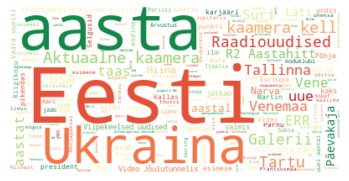

In [ ]:
getWordCloud(unbaitText)